In [275]:
# ✅ Project Introduction (Markdown)
# This project aims to analyze Serie A football match data and build machine learning models to predict match outcomes.
# Multiple models are compared: Decision Tree, Random Forest, and Stacking Ensemble to determine the most accurate one.


In [54]:
# ✅ Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [55]:
# ✅ Load the data
# Read the CSV file and display the first few rows to understand its structure
df_mathces = pd.read_csv("matches_serie_A.csv")
df_mathces.head()

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
0,1,2024-08-18,18:30,Serie A,Matchweek 1,Sun,Away,L,0,3,...,Match Report,NaN,14.0,4.0,17.8,0.0,0,0,2025,Napoli
1,2,2024-08-25,20:45,Serie A,Matchweek 2,Sun,Home,W,3,0,...,Match Report,NaN,16.0,5.0,17.5,0.0,0,0,2025,Napoli
2,3,2024-08-31,20:45,Serie A,Matchweek 3,Sat,Home,W,2,1,...,Match Report,NaN,29.0,7.0,17.5,1.0,0,0,2025,Napoli
3,4,2024-09-15,18:00,Serie A,Matchweek 4,Sun,Away,W,4,0,...,Match Report,NaN,13.0,5.0,16.0,0.0,0,0,2025,Napoli
4,5,2024-09-21,18:00,Serie A,Matchweek 5,Sat,Away,D,0,0,...,Match Report,NaN,8.0,1.0,23.4,0.0,0,0,2025,Napoli


In [56]:
# ✅ Data Cleaning
# Drop the 'Notes' column and remove missing values
df_mathces = df_mathces .drop("Notes" , axis=1) # if we include this column all the rows will be deleted
df_mathces.dropna(inplace=True)
print(df_mathces .isna().sum())

Unnamed: 0       0
Date             0
Time             0
Comp             0
Round            0
Day              0
Venue            0
Result           0
GF               0
GA               0
Opponent         0
xG               0
xGA              0
Poss             0
Attendance       0
Captain          0
Formation        0
Opp Formation    0
Referee          0
Match Report     0
Sh               0
SoT              0
Dist             0
FK               0
PK               0
PKatt            0
Season           0
Team             0
dtype: int64


In [57]:
# ✅ Remove outliers using IQR
# This function removes rows with outliers from all numeric columns

def remove_outliers_iqr_all(df):
    numeric_cols = df.select_dtypes(include='number').columns
    mask = pd.Series([True] * len(df), index=df.index)  

    for col in numeric_cols:
        data = df[col].dropna()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        mask &= (df[col] >= lower) & (df[col] <= upper)

    return df[mask]  
df = remove_outliers_iqr_all(df_mathces )
print("Before cleaning", df_mathces .shape)
print("After cleaning", df.shape)

Before cleaning (3115, 28)
After cleaning (2268, 28)


In [58]:
# ✅ Feature Engineering: Parse formation
# Instead of using OneHot for formations like "4-3-3", we extract key components (Def/Mid/Att) to reduce dimensionality
df["Formation"].value_counts()

Formation
3-4-3         466
4-2-3-1       459
3-5-2         415
4-3-3         382
3-4-1-2       144
4-4-2          84
4-3-1-2        77
3-5-1-1        52
4-1-4-1        41
3-1-4-2        36
4-3-2-1        34
4-4-1-1        28
5-3-2          22
4-5-1           9
4-1-2-1-2◆      7
5-4-1           6
4-1-3-2         5
4-2-2-2         1
Name: count, dtype: int64

In [59]:

def parse_formation(formation):
    parts = formation.split('-')
    parts = list(map(int, parts))
    return {
        'Def': parts[0],
        'Mid': sum(parts[1:-1]) if len(parts) > 2 else parts[1],
        'Att': parts[-1],
        'Length': len(parts)
    }

In [60]:
formation_parsed = df['Formation'].str.replace('◆', '').apply(parse_formation)
formation_df = pd.DataFrame(list(formation_parsed))
df = pd.concat([df, formation_df], axis=1)

In [61]:
# Parse opponent formation in the same way
def parse_formation_opp(formation):
    parts = formation.split('-')
    parts = list(map(int, parts))
    return {
        'Opp_Def': parts[0],
        'Opp_Mid': sum(parts[1:-1]) if len(parts) > 2 else parts[1],
        'Opp_Att': parts[-1],
        'Opp_Length': len(parts)
    }
parsed_opp_formation = df['Opp Formation'].dropna().apply(parse_formation_opp)

opp_formation_df = pd.DataFrame(parsed_opp_formation.tolist())

df = pd.concat([df, opp_formation_df], axis=1)

In [62]:
# Here, I excluded the months from the date column to generate the Season column.
df["Date"] = pd.to_datetime(df["Date"])
df["month"] = df["Date"].dt.month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Date'].dt.month.apply(get_season)

In [11]:
df["Season"]

0       Summer
1       Summer
3       Autumn
4       Autumn
5       Autumn
         ...  
2238    Autumn
2241    Autumn
2249    Autumn
2253    Autumn
2264    Autumn
Name: Season, Length: 2895, dtype: object

In [12]:
#  Attendance and Date and Time will not effect our model so there is no need to include them 
df = df.drop(["Attendance" , "Date" , "Time"] , axis=1)

In [13]:
df.columns.tolist()

['Unnamed: 0',
 'Comp',
 'Round',
 'Day',
 'Venue',
 'Result',
 'GF',
 'GA',
 'Opponent',
 'xG',
 'xGA',
 'Poss',
 'Captain',
 'Formation',
 'Opp Formation',
 'Referee',
 'Match Report',
 'Sh',
 'SoT',
 'Dist',
 'FK',
 'PK',
 'PKatt',
 'Season',
 'Team',
 'Def',
 'Mid',
 'Att',
 'Length',
 'Opp_Def',
 'Opp_Mid',
 'Opp_Att',
 'Opp_Length',
 'month']

In [14]:
df

,Unnamed: 0,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,...,Team,Def,Mid,Att,Length,Opp_Def,Opp_Mid,Opp_Att,Opp_Length,month
0,1.0,Serie A,Matchweek 1,Sun,Away,L,0.0,3.0,Hellas Verona,1.0,...,Napoli,3.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,8.0
1,2.0,Serie A,Matchweek 2,Sun,Home,W,3.0,0.0,Bologna,2.5,...,Napoli,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,8.0
3,4.0,Serie A,Matchweek 4,Sun,Away,W,4.0,0.0,Cagliari,1.9,...,Napoli,4.0,5.0,1.0,4.0,4.0,5.0,1.0,4.0,9.0
4,5.0,Serie A,Matchweek 5,Sat,Away,D,0.0,0.0,Juventus,0.3,...,Napoli,4.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,9.0
5,7.0,Serie A,Matchweek 6,Sun,Home,W,2.0,0.0,Monza,1.1,...,Napoli,4.0,3.0,3.0,3.0,4.0,5.0,1.0,3.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,5.0,2.0,3.0,3.0,4.0,3.0,3.0,NaN
2241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,5.0,1.0,4.0,4.0,5.0,1.0,4.0,NaN
2249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,5.0,2.0,3.0,3.0,4.0,3.0,3.0,NaN
2253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,3.0,3.0,3.0,3.0,5.0,2.0,3.0,NaN


In [15]:
# Feature Selection: If we include all features in the dataframe, it can lead to incorrect predictions and increased processing time.
# Approach: We will select relevant columns based on our domain knowledge and further refine them after training the model using feature_importances_.

df = df[["Season", "Venue", "Result", "xG", "xGA", "Poss", "Mid", "Def", "Att" , "Team" , "Opponent" , "Opp_Def" , "Opp_Mid" , "Opp_Att"]]


In [16]:
df.dropna(inplace=True)
print(df.isna().sum())
print(df.shape)

Season      0
Venue       0
Result      0
xG          0
xGA         0
Poss        0
Mid         0
Def         0
Att         0
Team        0
Opponent    0
Opp_Def     0
Opp_Mid     0
Opp_Att     0
dtype: int64
(1641, 14)


C:\Users\r7amm\AppData\Local\Temp\ipykernel_3024\3654597823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [17]:
# ✅ Model Preparation
# We'll try to predict the result (Win/Draw/Loss)
y = df["Result"] # the prediciton column 
X = df.drop("Result", axis=1)

In [18]:
cat_col = [col for col in X.columns if X[col].dtype == "object"]
cat_col

['Season', 'Venue', 'Team', 'Opponent']

In [19]:
# Encoding Categorical Variables: Since the model does not accept object (string) values, we will encode them into numerical format.
preprocessor = ColumnTransformer ([
    ("cat" , OneHotEncoder() , cat_col)
] , remainder = "passthrough"
                                 )

In [20]:
# Model Selection - Decision Tree: I chose the Decision Tree algorithm because it can effectively handle non-linear relationships between features.
pipeline = Pipeline([
    ("preprocess" , preprocessor) , 
    ("tree" , DecisionTreeClassifier(random_state=42))
])

In [21]:
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [22]:
# Feature Importance Analysis: After training the model, we can evaluate the importance of each feature.
# This allows us to test different column combinations, analyze their impact percentages, and make informed decisions about feature selection.
pipeline.fit(x_train, y_train)
import numpy as np
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_col)
num_features = [col for col in X.columns if col not in cat_col]
all_features = np.concatenate([cat_features, num_features])

importances = pipeline.named_steps['tree'].feature_importances_

feature_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)
print(feature_importances)

xGA                 0.166262
xG                  0.121587
Poss                0.100711
Opp_Mid             0.026970
Opp_Att             0.026124
                      ...   
Team_Como           0.002625
Team_Sampdoria      0.001323
Team_Cremonese      0.001148
Opponent_Como       0.000000
Opponent_Venezia    0.000000
Length: 67, dtype: float64


In [23]:
y_pred = pipeline.predict(x_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.47


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           D       0.30      0.33      0.31        93
           L       0.57      0.52      0.54       125
           W       0.52      0.52      0.52       111

    accuracy                           0.47       329
   macro avg       0.46      0.46      0.46       329
weighted avg       0.48      0.47      0.47       329



In [25]:
# Model Performance & Next Steps: While the initial results are promising  
# we will now experiment with additional models to further improve performance.
random_df = df 
random_df

,Season,Venue,Result,xG,xGA,Poss,Mid,Def,Att,Team,Opponent,Opp_Def,Opp_Mid,Opp_Att
0,Summer,Away,L,1.0,1.7,67.0,4.0,3.0,3.0,Napoli,Hellas Verona,3.0,4.0,3.0
1,Summer,Home,W,2.5,0.6,39.0,4.0,3.0,3.0,Napoli,Bologna,4.0,3.0,3.0
3,Autumn,Away,W,1.9,1.0,49.0,5.0,4.0,1.0,Napoli,Cagliari,4.0,5.0,1.0
4,Autumn,Away,D,0.3,0.3,36.0,3.0,4.0,3.0,Napoli,Juventus,3.0,4.0,3.0
5,Autumn,Home,W,1.1,0.3,49.0,3.0,4.0,3.0,Napoli,Monza,4.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,Winter,Away,D,1.2,2.1,28.0,5.0,4.0,1.0,Sampdoria,Monza,4.0,5.0,1.0
2263,Winter,Home,D,0.5,1.8,35.0,5.0,3.0,2.0,Sampdoria,Inter,4.0,5.0,1.0
2265,Winter,Away,L,0.5,1.6,43.0,3.0,4.0,3.0,Sampdoria,Lazio,4.0,5.0,1.0
2266,Spring,Home,D,0.5,0.8,56.0,4.0,4.0,2.0,Sampdoria,Salernitana,3.0,4.0,3.0


In [26]:
y_random = df["Result"]
X_random = df.drop("Result", axis=1)

In [27]:
x_train_random , x_test_random , y_train_random , y_test_random = train_test_split(X , y , test_size=0.2 , random_state=42)

In [28]:
cat_col_random = [col for col in X.columns if X[col].dtype == "object"]
cat_col_random

['Season', 'Venue', 'Team', 'Opponent']

In [29]:
preprocessor_random = ColumnTransformer ([
    ("cat" , OneHotEncoder() , cat_col_random)
] , remainder = "passthrough"
                                 )

In [30]:
# Random Forest Overview:
# A Random Forest is an ensemble method that extends the Decision Tree algorithm. 
# It operates by constructing multiple decision trees during training, with each tree using:
# 1 - A unique bootstrap sample of the training data
# 2 - A random subset of features at each split
# This approach enhances model robustness and reduces overfitting compared to a single decision tree.
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ("preprocess" , preprocessor_random) , 
    ("rf" , RandomForestClassifier(random_state=42 , n_jobs=-1))
])

In [31]:
param_grid = {
    "rf__n_estimators" : [i for i in range(50 , 500 , 50)] , 
    "rf__max_depth" : [None , 5 , 10] , 
    "rf__max_features" : ["sqrt" , "log2"]

}

In [63]:
# GridSearchCV Overview:
# GridSearchCV automates hyperparameter tuning by:
# 1 - Performing k-fold cross-validation to evaluate model performance
# 2 - Exhaustively testing all specified parameter combinations
# 3 - Identifying the optimal parameters for our model
# This ensures we select the best configuration while maintaining reliable performance estimates.
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(pipeline , param_grid , cv=5 , n_jobs=-1)
grid_search.fit(x_train_random , y_train_random)

SyntaxError: invalid decimal literal (3702134387.py, line 4)

In [33]:
# best params :
print("best_params" , grid_search.best_params_)
print("best_params" , grid_search.best_score_.round(2))
print("Test set score:", grid_search.score(x_test, y_test))

best_params {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
best_params 0.54
Test set score: 0.547112462006079


In [34]:
y_pred_random = grid_search.predict(x_test_random)

In [35]:
from sklearn.metrics import classification_report
# Performance Improvement: We observe significant enhancement in the model outputs.
# As a final optimization step, we will implement one last improvement to maximize performance.
print(classification_report(y_test_random, y_pred_random))

              precision    recall  f1-score   support

           D       0.38      0.25      0.30        93
           L       0.59      0.73      0.65       125
           W       0.58      0.59      0.59       111

    accuracy                           0.55       329
   macro avg       0.52      0.52      0.51       329
weighted avg       0.53      0.55      0.53       329



In [36]:
df_stack = df 

In [37]:
y = df["Result"]
X = df.drop("Result", axis=1)

In [38]:
x_train_stack , x_test_stack , y_train_stack , y_test_stack = train_test_split(X , y , test_size=0.2 , random_state=42)

In [39]:
categorical_cols_stack = [col for col in X.columns if X[col].dtype == "object"]
numerical_cols_stack = [col for col in X.columns if X[col].dtype != "object"]


In [40]:
from sklearn.preprocessing import StandardScaler
preprocesso_stack = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols_stack),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_stack)
])

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

In [42]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    passthrough=False,
    n_jobs=-1
)

In [43]:
param_grid = {
    'stack__final_estimator__C': [0.01, 0.1, 1.0],  
    'stack__final_estimator__penalty': ['l2'],       
    'stack__final_estimator__solver': ['lbfgs'],     
    'stack__final_estimator__max_iter': [1000],      
    'stack__final_estimator__class_weight': [None],  
}

In [44]:
pipeline_stack = Pipeline([
    ('preprocessing', preprocesso_stack),
    ('stack', stacking_clf)
])

In [45]:
grid_search = GridSearchCV(
    estimator=pipeline_stack,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
)

In [46]:
grid_search.fit(x_train_stack, y_train_stack)

,estimator,Pipeline(step... n_jobs=-1))])
,param_grid,"{'stack__final_estimator__C': [0.01, 0.1, ...], 'stack__final_estimator__class_weight': [None], 'stack__final_estimator__max_iter': [1000], 'stack__final_estimator__penalty': ['l2'], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_model = grid_search.best_estimator_
y_pred_stack = best_model.predict(x_test_stack)

In [48]:
accuracy = accuracy_score(y_test_stack, y_pred_stack)
report = classification_report(y_test_stack, y_pred_stack)
conf_matrix = confusion_matrix(y_test_stack, y_pred_stack)

# 4. عرض النتائج
print("✅ Accuracy:", accuracy)
print("\n📊 Classification Report:\n", report)
print("\n🧱 Confusion Matrix:\n", conf_matrix)

✅ Accuracy: 0.5562310030395137

📊 Classification Report:
               precision    recall  f1-score   support

           D       0.40      0.17      0.24        93
           L       0.59      0.73      0.65       125
           W       0.56      0.68      0.62       111

    accuracy                           0.56       329
   macro avg       0.52      0.53      0.50       329
weighted avg       0.53      0.56      0.52       329


🧱 Confusion Matrix:
 [[16 40 37]
 [12 91 22]
 [12 23 76]]


In [49]:
df_stack["Result"].value_counts()

Result
L    618
W    535
D    488
Name: count, dtype: int64

In [50]:
df[df["Result"] == "D"]

,Season,Venue,Result,xG,xGA,Poss,Mid,Def,Att,Team,Opponent,Opp_Def,Opp_Mid,Opp_Att
4,Autumn,Away,D,0.3,0.3,36.0,3.0,4.0,3.0,Napoli,Juventus,3.0,4.0,3.0
22,Winter,Away,D,0.4,0.5,49.0,3.0,4.0,3.0,Napoli,Roma,3.0,4.0,3.0
23,Winter,Home,D,1.1,0.8,62.0,3.0,4.0,3.0,Napoli,Udinese,3.0,5.0,2.0
24,Winter,Away,D,0.3,0.7,47.0,3.0,4.0,3.0,Napoli,Lazio,3.0,5.0,2.0
26,Spring,Home,D,1.8,0.3,62.0,5.0,4.0,1.0,Napoli,Inter,3.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,Summer,Home,D,0.8,1.5,44.0,5.0,3.0,2.0,Sampdoria,Lazio,4.0,4.0,2.0
2250,Autumn,Away,D,0.6,0.8,49.0,5.0,3.0,2.0,Sampdoria,Bologna,4.0,3.0,3.0
2262,Winter,Away,D,1.2,2.1,28.0,5.0,4.0,1.0,Sampdoria,Monza,4.0,5.0,1.0
2263,Winter,Home,D,0.5,1.8,35.0,5.0,3.0,2.0,Sampdoria,Inter,4.0,5.0,1.0


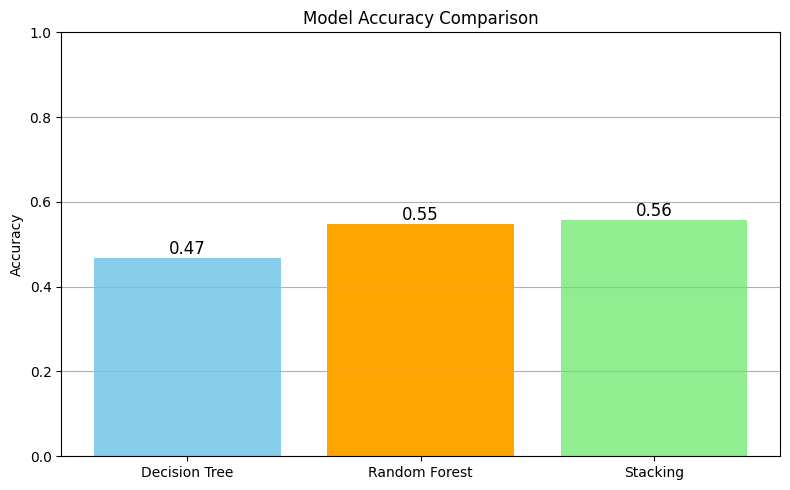

In [53]:
# Accuracy Improvement Visualization:
# Create a comparative visualization to demonstrate the model's accuracy improvements across different iterations/versions
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

models = ['Decision Tree', 'Random Forest', 'Stacking']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_random),
    accuracy_score(y_test, y_pred_stack)
]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'orange', 'lightgreen'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png")  # Save the figure
plt.show()


In [ ]:
## 📌 Summary

# The model's accuracy was acceptable as a starting point.  
# However, from my understanding, one of the main challenges was predicting **draw games**.  
# This difficulty likely arises because draw games often share similar statistical features with both wins and losses, 
# making it harder for the model to distinguish them accurately.
